# Predicting painting authors

In this notebook, I will build a model to predict authors of paintings. I will use the [dataset](https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time) from Kaggle that has 8,000+ paintings by 50 most famous artists to train the model.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
tf.get_logger().setLevel('ERROR')

Let's start with exploring the information about the paintings in the dataset. Luckily, there is a csv file summarizing information about all paintings in the dataset and their authors. I will read it as a pandas dataframe.

In [11]:
artists = pd.read_csv(r'data\artists.csv').drop(columns=['id', 'bio', 'wikipedia'])

#sorting the dataframe by the number of paintings in the dataset
artists.sort_values('paintings', ascending=False).reset_index(drop=True)

,name,years,genre,nationality,paintings
0,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,877
1,Edgar Degas,1834 - 1917,Impressionism,French,702
2,Pablo Picasso,1881 - 1973,Cubism,Spanish,439
3,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,336
4,Albrecht Durer,1471 - 1528,Northern Renaissance,German,328
5,Paul Gauguin,1848 – 1903,"Symbolism,Post-Impressionism",French,311
6,Francisco Goya,1746 - 1828,Romanticism,Spanish,291
7,Rembrandt,1606 - 1669,Baroque,Dutch,262
8,Alfred Sisley,1839 - 1899,Impressionism,"French,British",259
9,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,255


Vincent van Gogh has the most paintings in the dataset, followed by Edgar Degas and Pablo Picasso. The difference between artists withe the most and the least paintings is large, meaning that the dataset is imbalanced. I'll deal with it later.

Each artist in the dataset is associated with one or more genres. Let's have a look at the distributrion of artists' genres.

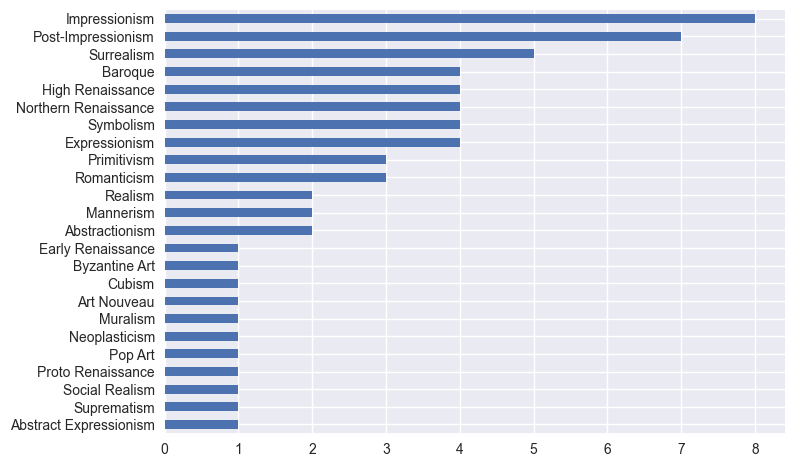

In [3]:
#getting all genres from the genre column
genre_count = artists.genre.str.get_dummies(sep=',').sum().sort_values()

#plotting the number of genres in the dataset
genre_count.plot.barh()
plt.show()

Impressionism and Post-Impressionism are the most popular genres, if we only count individual artists. There are also plenty of artists associated with different periods and types of Renaissance art.

The paintings is stored on my local machine. Below, I display some of the paintings, selected randomly. The code used here is adapted from this Stackoverflow [answer](https://stackoverflow.com/a/60443998).

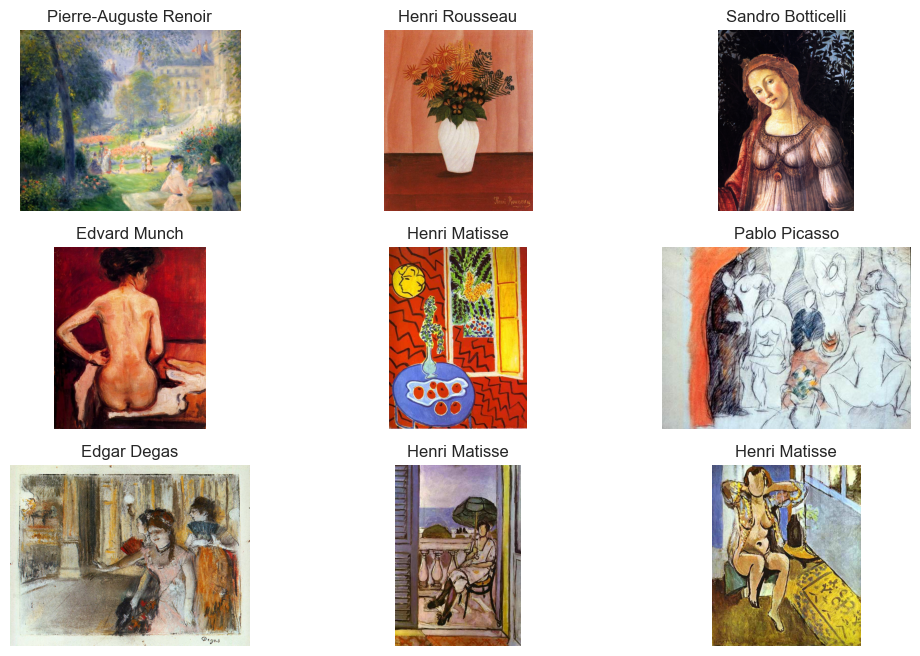

In [6]:
#getting the list of all filepaths
train_folder = 'data/artists'
images = {}
for folder in os.listdir(train_folder):
    for image in os.listdir(train_folder + '/' + folder):
        filename = os.path.join(train_folder, folder, image)
        author = folder.replace('_', ' ')
        images[filename] = author
        
plt.figure(1, figsize=(12, 8))

#displaying nine randomly selected images
n = 0
for i in range(9):
    n += 1
    random_img = random.choice(list(images.keys()))
    imgs = plt.imread(random_img)
    plt.subplot(3, 3, n)
    plt.axis('off')
    plt.imshow(imgs)
    plt.title(images[random_img])

plt.show()

Next, I will build a simple deep learning network using TensorFlow to try to predict authors of the paintings. I will start with generating a dataset from the images in the folder on my local machine. I will resize all images to the 224x224 size and split them into 80 percent training and 20 percent validation dataset.

In [5]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    'data/artists',
    validation_split=0.2,
    subset='training',
    seed=17,
    image_size=image_size,
    batch_size=batch_size
    )

valid_ds = tf.keras.utils.image_dataset_from_directory(
    'data/artists',
    validation_split=0.2,
    subset='validation',
    seed=17,
    image_size=image_size,
    batch_size=batch_size
)

Found 8446 files belonging to 50 classes.
Using 6757 files for training.
Found 8446 files belonging to 50 classes.
Using 1689 files for validation.


Given the relatvely small number of images in the dataset, I will use data augmentation to mitigate overfitting and allow the model generalize better to unseen images. I will use three data augmentation layers that adds random noise to images and randomly increased or decreases brightness and contrast of images. 

In [38]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.5),
    tf.keras.layers.RandomContrast(0.5)
])

In [9]:
def visualize(original, augmented):
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original[0].numpy().astype("int32"))
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented[0].numpy().astype("int32"))
    plt.axis('off')

Below, I will compare the original resized images with the same image that was augmented using RandomContrast and RandomBrightness.

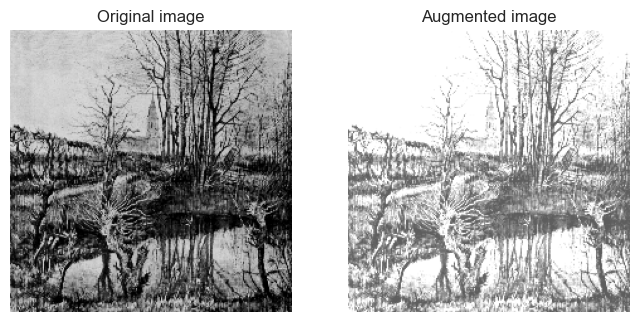

In [12]:
image, label = next(iter(train_ds))
augmented_image = tf.keras.layers.RandomBrightness(0.5)(
            tf.expand_dims(image[0], 0), training=True
            )
visualize(image, augmented_image)

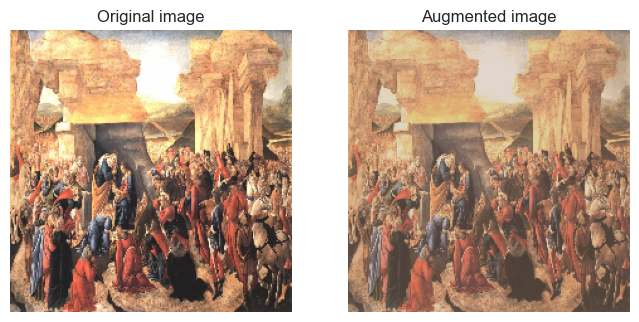

In [ ]:
image, label = next(iter(train_ds))
augmented_image = tf.keras.layers.RandomContrast(0.5)(
            tf.expand_dims(image[0], 0), training=True
            )
visualize(image, augmented_image)

I will use the data aumentation layer as the first layer of the network. I will add several convolutional layers, as well as max pooling and dropouts layers for regularization. The final layer will output a classification prediction with probabilities of a painting being authored by all of 50 possible artists.

In [14]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='softmax')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

After compiling the model, I will train the network for 15 epochs and then evaluate the accuracy of its predictions on a validation set.

In [15]:
epochs = 15

history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/15
212/212 [==============================] - 349s 2s/step - loss: 3.6006 - accuracy: 0.1126 - val_loss: 3.4189 - val_accuracy: 0.1439
Epoch 2/15
212/212 [==============================] - 305s 1s/step - loss: 3.4296 - accuracy: 0.1443 - val_loss: 3.3445 - val_accuracy: 0.1492
Epoch 3/15
212/212 [==============================] - 329s 2s/step - loss: 3.3160 - accuracy: 0.1604 - val_loss: 3.1350 - val_accuracy: 0.2149
Epoch 4/15
212/212 [==============================] - 323s 2s/step - loss: 3.1604 - accuracy: 0.2002 - val_loss: 2.9873 - val_accuracy: 0.2380
Epoch 5/15
212/212 [==============================] - 316s 1s/step - loss: 3.0297 - accuracy: 0.2254 - val_loss: 2.8598 - val_accuracy: 0.2623
Epoch 6/15
212/212 [==============================] - 315s 1s/step - loss: 2.8598 - accuracy: 0.2574 - val_loss: 2.7922 - val_accuracy: 0.2954
Epoch 7/15
212/212 [==============================] - 274s 1s/step - loss: 2.6536 - accuracy: 0.3013 - val_loss: 2.7655 - val_accuracy: 0.2919

To see how the accuracy of predictions on the train and test sets changed after each epochs, I'll create a simple plot.

In [16]:
def plot_accuracy(history, epochs):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, epochs + 1)

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

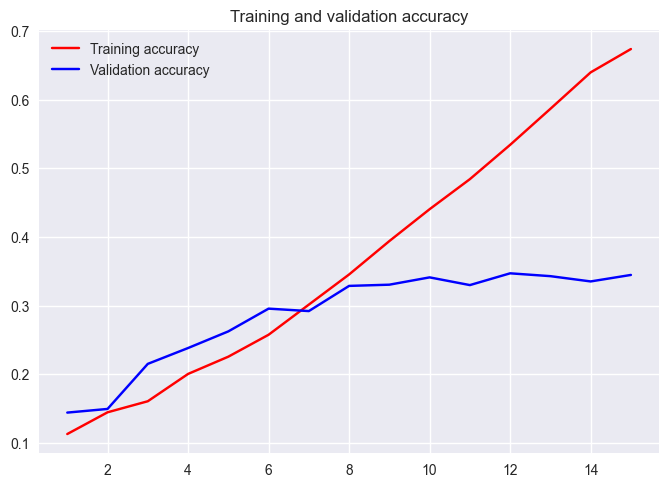

In [17]:
plot_accuracy(history, epochs)

The accuracy of the model's prediction for the validation set is rather low. It peaked at around 34 percent after 10 epochs and flattened after that, while tra training accuracy continued to increase linearly. This is not surpising for the rather simple neural network archirecture given the complicated nature of the task, high number of possible classification labels, and rather limited number of training examples.

To improve the performance of the model, I will use transfer learning. I will use three pre-trained networls: VGG16, ResNet, and Efficientnet. To adapt them to the painting dataset and the classification task, I will add the 50-label classification layer on the top of the network and train it on the dataset.

In [2]:
def compile_model(original_model):
    base_model = original_model(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    for layers in base_model.layers:
        layers.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(50, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

    return model

In [3]:
def train_model(model, epochs):

    history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs
    )
    
    return history

In [6]:
vgg16_model = compile_model(tf.keras.applications.vgg16.VGG16)
vgg16_history = train_model(vgg16_model, 10)

Epoch 1/10
212/212 [==============================] - 764s 4s/step - loss: 6.0231 - accuracy: 0.1942 - val_loss: 3.8986 - val_accuracy: 0.3268
Epoch 2/10
212/212 [==============================] - 754s 4s/step - loss: 2.8731 - accuracy: 0.4274 - val_loss: 2.9335 - val_accuracy: 0.4435
Epoch 3/10
212/212 [==============================] - 808s 4s/step - loss: 1.9335 - accuracy: 0.5482 - val_loss: 2.6176 - val_accuracy: 0.4748
Epoch 4/10
212/212 [==============================] - 792s 4s/step - loss: 1.4614 - accuracy: 0.6310 - val_loss: 2.4373 - val_accuracy: 0.5021
Epoch 5/10
212/212 [==============================] - 784s 4s/step - loss: 1.1482 - accuracy: 0.6919 - val_loss: 2.4208 - val_accuracy: 0.5145
Epoch 6/10
212/212 [==============================] - 783s 4s/step - loss: 0.9506 - accuracy: 0.7308 - val_loss: 2.2819 - val_accuracy: 0.5317
Epoch 7/10
212/212 [==============================] - 764s 4s/step - loss: 0.7891 - accuracy: 0.7742 - val_loss: 2.2721 - val_accuracy: 0.5394

In [7]:
resnet50_model = compile_model(tf.keras.applications.resnet50.ResNet50)
resnet50_history = train_model(resnet50_model, 10)

Epoch 1/10
212/212 [==============================] - 465s 2s/step - loss: 2.2398 - accuracy: 0.4296 - val_loss: 1.6114 - val_accuracy: 0.5619
Epoch 2/10
212/212 [==============================] - 508s 2s/step - loss: 1.1365 - accuracy: 0.6777 - val_loss: 1.4295 - val_accuracy: 0.5938
Epoch 3/10
212/212 [==============================] - 502s 2s/step - loss: 0.8035 - accuracy: 0.7770 - val_loss: 1.3286 - val_accuracy: 0.6412
Epoch 4/10
212/212 [==============================] - 499s 2s/step - loss: 0.5992 - accuracy: 0.8427 - val_loss: 1.2818 - val_accuracy: 0.6442
Epoch 5/10
212/212 [==============================] - 496s 2s/step - loss: 0.4524 - accuracy: 0.8874 - val_loss: 1.2809 - val_accuracy: 0.6459
Epoch 6/10
212/212 [==============================] - 491s 2s/step - loss: 0.3504 - accuracy: 0.9227 - val_loss: 1.2439 - val_accuracy: 0.6649
Epoch 7/10
212/212 [==============================] - 490s 2s/step - loss: 0.2762 - accuracy: 0.9488 - val_loss: 1.2553 - val_accuracy: 0.6584

In [8]:
efficientnetb0_model = compile_model(tf.keras.applications.efficientnet.EfficientNetB0)
efficientnetb0_history = train_model(efficientnetb0_model, 10)

Epoch 1/10
212/212 [==============================] - 297s 1s/step - loss: 2.4067 - accuracy: 0.3993 - val_loss: 1.7690 - val_accuracy: 0.5394
Epoch 2/10
212/212 [==============================] - 317s 1s/step - loss: 1.4357 - accuracy: 0.6324 - val_loss: 1.4510 - val_accuracy: 0.6169
Epoch 3/10
212/212 [==============================] - 324s 2s/step - loss: 1.1143 - accuracy: 0.7225 - val_loss: 1.3035 - val_accuracy: 0.6631
Epoch 4/10
212/212 [==============================] - 309s 1s/step - loss: 0.9278 - accuracy: 0.7705 - val_loss: 1.2285 - val_accuracy: 0.6702
Epoch 5/10
212/212 [==============================] - 303s 1s/step - loss: 0.7914 - accuracy: 0.8079 - val_loss: 1.1802 - val_accuracy: 0.6803
Epoch 6/10
212/212 [==============================] - 313s 1s/step - loss: 0.6921 - accuracy: 0.8329 - val_loss: 1.1468 - val_accuracy: 0.6827
Epoch 7/10
212/212 [==============================] - 310s 1s/step - loss: 0.6113 - accuracy: 0.8637 - val_loss: 1.1150 - val_accuracy: 0.6933

Among the three pre-trained models I used, EfficientNet showed the best performance in terms of accuracy of predictions and training time. It also overfitted slightly less then both VGG16 and ResNet50. Let's plot the final training and validation accuracies of the models.

In [33]:
vgg_train_accuracy = vgg16_history.history['accuracy'][-1] * 100
resnet_train_accuracy = resnet50_history.history['accuracy'][-1] * 100
efficientnet_train_accuracy = efficientnetb0_history.history['accuracy'][-1] * 100

vgg_val_accuracy = vgg16_history.history['val_accuracy'][-1] * 100
resnet_val_accuracy = resnet50_history.history['val_accuracy'][-1] * 100
efficientnet_val_accuracy = efficientnetb0_history.history['val_accuracy'][-1] * 100

train_accuracies = [vgg_train_accuracy, resnet_train_accuracy, efficientnet_train_accuracy]
val_accuracies = [vgg_val_accuracy, resnet_val_accuracy, efficientnet_val_accuracy]
algorithms = ['VGG16', 'ResNet50', 'EfficientNetB0']

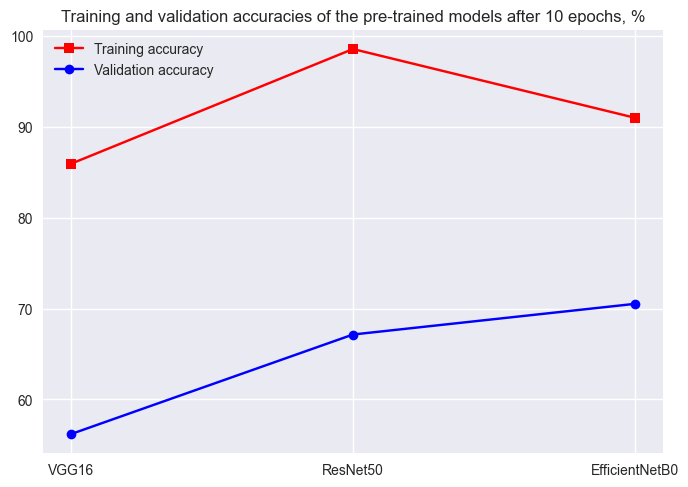

In [34]:
plt.plot(algorithms, train_accuracies, 'r', label='Training accuracy', marker='s')
plt.plot(algorithms, val_accuracies, 'b', label='Validation accuracy', marker='o')
plt.title('Training and validation accuracies of the pre-trained models after 10 epochs, %')
plt.legend()

plt.show()

Next, I will investigate how the accuracy of predictions by the model differed among different painters to see if I can spot any interesting patterns.

In [9]:
# https://stackoverflow.com/a/67256122
predictions = np.array([])
labels =  np.array([])

for x, y in valid_ds:
    predictions = np.concatenate([predictions, np.argmax(efficientnetb0_model.predict(x, verbose=0), axis=-1)])
    labels = np.concatenate([labels, y.numpy()])

In [13]:
artist_list = sorted(list(artists.name))
artist_dict = {i: style for i, style in enumerate(artist_list)}

pred_artists = [artist_dict[k] for k in predictions]
actual_artists = [artist_dict[k] for k in labels]
results_df = pd.DataFrame({'predicted': pred_artists, 'actual': actual_artists})
results_df['result'] = results_df.predicted == results_df.actual

results_df_grouped = results_df.groupby('actual')['result'].mean()
correct_by_artist = pd.DataFrame({'name': results_df_grouped.index, 'share_correct': results_df_grouped.values})

artist_count_dict = dict(zip(artists.name, artists.paintings))
correct_by_artist['count'] = correct_by_artist.name.map(artist_count_dict)

correct_by_artist = correct_by_artist.sort_values('share_correct', ascending=False)
correct_by_artist

,name,share_correct,count
25,Jackson Pollock,1.000000,24
2,Amedeo Modigliani,0.941176,193
1,Alfred Sisley,0.914894,259
18,Giotto di Bondone,0.894737,119
0,Albrecht Durer,0.885714,328
48,Vincent van Gogh,0.868571,877
36,Paul Klee,0.850000,188
4,Andy Warhol,0.846154,181
10,Edgar Degas,0.843972,702
45,Sandro Botticelli,0.842105,164


Finally, I will train the EfficientNet model on the full dataset.

In [15]:
full_ds = tf.keras.utils.image_dataset_from_directory(
    'data/artists',
    seed=17,
    image_size=image_size,
    batch_size=batch_size,
)

Found 8446 files belonging to 50 classes.


In [17]:
efficientnetb0_model = compile_model(tf.keras.applications.efficientnet.EfficientNetB0)

epochs = 10

history = efficientnetb0_model.fit(
  full_ds,
  epochs=epochs
)

Epoch 1/10
264/264 [==============================] - 302s 1s/step - loss: 2.2758 - accuracy: 0.4313
Epoch 2/10
264/264 [==============================] - 283s 1s/step - loss: 1.3461 - accuracy: 0.6564
Epoch 3/10
264/264 [==============================] - 284s 1s/step - loss: 1.0517 - accuracy: 0.7282
Epoch 4/10
264/264 [==============================] - 276s 1s/step - loss: 0.8744 - accuracy: 0.7803
Epoch 5/10
264/264 [==============================] - 255s 966ms/step - loss: 0.7556 - accuracy: 0.8121
Epoch 6/10
264/264 [==============================] - 256s 967ms/step - loss: 0.6656 - accuracy: 0.8372
Epoch 7/10
264/264 [==============================] - 256s 969ms/step - loss: 0.5852 - accuracy: 0.8640
Epoch 8/10
264/264 [==============================] - 255s 963ms/step - loss: 0.5268 - accuracy: 0.8796
Epoch 9/10
264/264 [==============================] - 254s 962ms/step - loss: 0.4773 - accuracy: 0.8951
Epoch 10/10
264/264 [==============================] - 255s 965ms/step - los

After the model is trained, I will use it to develop a simple web app that will predict authors of famous paintings. I will use Gradio library and Hugging Face Spaces for this purpose. The app will be available [here](https://huggingface.co/spaces/osydorchuk/painting_authors).